## *Modeling exercises*

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

import warnings
warnings.filterwarnings("ignore")

import wrangle as wr
import evaluate as ev
import explore as ex

In [2]:
pd.options.display.float_format = '{:,.3f}'.format

1. Select a dataset with a continuous target variable.

2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.

In [59]:
train, validate, test = wr.split_zillow(wr.get_zillow())

In [40]:
train.shape

(1198465, 11)

In [5]:
1198465 * 0.95

1138541.75

In [4]:
train.head(1)

,id,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura,county_name,home_value
738365,1022663,2,1.000,1078,"1,950.000",67,"3,554.540",1,0,LA,260058


In [60]:
train = wr.handle_outliers(train)
validate = wr.handle_outliers(validate)
test = wr.handle_outliers(test)

In [7]:
train.shape

(1153185, 11)

In [8]:
train.describe()

,id,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura,home_value
count,"1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000","1,153,185.000"
mean,"1,491,482.858",3.230,2.135,"1,759.260","1,960.368",56.632,"4,880.228",0.664,0.077,"396,882.732"
std,"860,666.572",0.844,0.797,726.323,21.658,21.658,"3,756.772",0.473,0.267,"327,504.640"
min,31.000,0.000,0.000,102.000,"1,807.000",1.000,6.340,0.000,0.000,22.000
25%,"746,913.000",3.000,2.000,"1,245.000","1,949.000",43.000,"2,486.180",0.000,0.000,"184,270.000"
50%,"1,492,032.000",3.000,2.000,"1,594.000","1,958.000",59.000,"4,000.020",1.000,0.000,"318,309.000"
75%,"2,235,020.000",4.000,3.000,"2,120.000","1,974.000",68.000,"6,122.240",1.000,0.000,"508,827.000"
max,"2,982,282.000",5.000,4.500,"29,620.000","2,016.000",210.000,"30,998.730",1.000,1.000,"8,375,162.000"


In [61]:
columns_to_explore = [
 'bedrooms',
 'bathrooms',
 'sq_feet',
 'house_age',
 'tax_amount',
 'home_value']

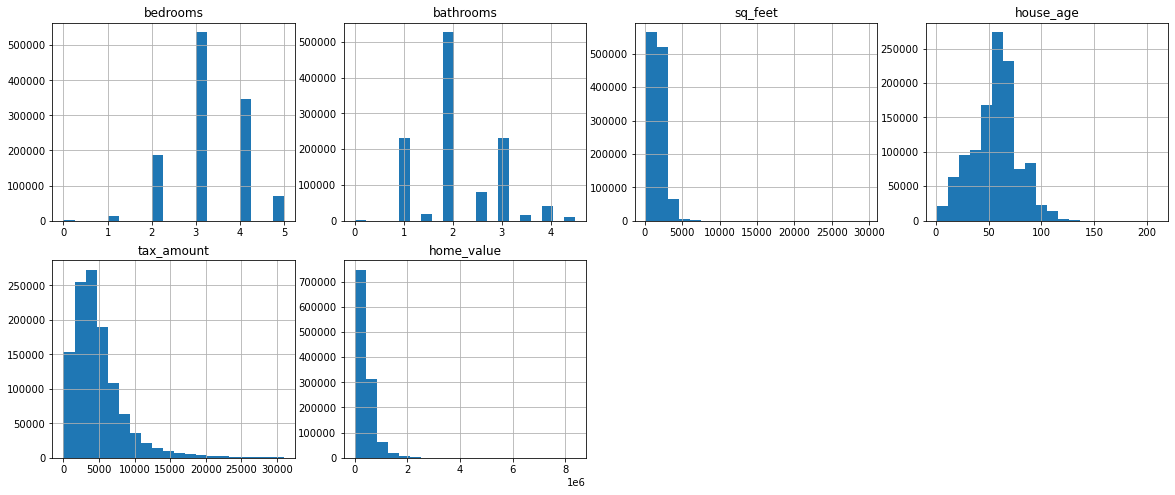

In [7]:
plt.figure(figsize=(20,8))
for i, col in enumerate(columns_to_explore):
    h =  ((i+2) // 4)
    subplot_number = (i+1) 
    plt.subplot(2, 4, subplot_number)
    plt.title(col)
    train[col].hist(bins = 20)

In [18]:
train.shape

(1134624, 11)

3. Work through all of the steps outlined in the lesson, from setting the baseline to selected a model and evaluating the final model on your test data.

In [62]:
# split data and move target var into separate Series
X_train, X_validate, X_test, y_train, y_validate, y_test = wr.full_split3_zillow(train, validate, test, 'home_value')

In [63]:
# drop id columns from data sets

X_train.drop(columns=['id', 'county_name'], inplace=True)
X_validate.drop(columns=['id', 'county_name'], inplace=True)
X_test.drop(columns=['id', 'county_name'], inplace=True)

In [64]:
X_train.head(1)

,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura
738365,2,1.000,1078,"1,950.000",67,"3,554.540",1,0


In [65]:
X_train.iloc[:, :-2].head(1)

,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount
738365,2,1.000,1078,"1,950.000",67,"3,554.540"


In [46]:
from sklearn.preprocessing import StandardScaler

In [66]:
sc = StandardScaler()

In [67]:
X_train.iloc[:, :-2] = sc.fit_transform(X_train.iloc[:, :-2])
X_validate.iloc[:, :-2] = sc.transform(X_validate.iloc[:, :-2])
X_test.iloc[:, :-2] = sc.transform(X_test.iloc[:, :-2])

In [68]:
X_train.head(1)

,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura
738365,-1.458,-1.424,-0.938,-0.479,0.479,-0.353,1,0


In [69]:
X_validate.head(1)

,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura
493957,0.912,1.086,0.780,0.491,-0.491,0.819,0,0


In [70]:
X_test.head(1)

,bedrooms,bathrooms,sq_feet,year_built,house_age,tax_amount,LA,Ventura
2018398,0.912,1.086,0.479,0.445,-0.445,0.454,1,0


In [16]:
y_train[:5]

738365     260058
1269373    286165
590554     473803
869106     112482
1718876    216810
Name: home_value, dtype: int64

In [71]:
# create a DataFrame to keep predictions of all models

train_pred = pd.DataFrame({
    'actual': y_train
})

valid_pred = pd.DataFrame({
    'actual': y_validate
})
train_pred['baseline'] = y_train.mean()
valid_pred['baseline'] = y_validate.mean()

####  *Simple Linear Regression*

In [72]:
# Based on previous explorations we know that tax_amount has a highest correlation with home_value

slr = LinearRegression()
slr.fit(X_train.tax_amount.values.reshape(-1, 1), y_train)

LinearRegression()

In [73]:
train_pred['simple_lr'] = slr.predict(X_train.tax_amount.values.reshape(-1, 1))
valid_pred['simple_lr'] = slr.predict(X_validate.tax_amount.values.reshape(-1, 1))

In [74]:
train_pred.head()

,actual,baseline,simple_lr
738365,260058,"396,882.732","283,758.069"
1269373,286165,"396,882.732","234,864.075"
590554,473803,"396,882.732","449,709.906"
869106,112482,"396,882.732","105,398.840"
1718876,216810,"396,882.732","224,530.271"


In [75]:
valid_pred.head()

,actual,baseline,simple_lr
493957,774790,"397,122.076","659,275.344"
943659,49029,"397,122.076","72,872.533"
918584,1651006,"397,122.076","1,689,930.155"
1081016,300689,"397,122.076","292,847.720"
1536342,135257,"397,122.076","155,056.563"


#### *Multiple Linear Regression*

In [49]:
X_train.columns.tolist()

['bedrooms',
 'bathrooms',
 'sq_feet',
 'year_built',
 'house_age',
 'tax_amount',
 'LA',
 'Ventura']

In [76]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

LinearRegression()

In [77]:
train_pred['multiple_lr'] = mlr.predict(X_train)
valid_pred['multiple_lr'] = mlr.predict(X_validate)

In [78]:
mlr2 = LinearRegression()
rfe = RFE(mlr2, n_features_to_select=3)
rfe.fit(X_train.drop(columns='year_built'), y_train)

RFE(estimator=LinearRegression(), n_features_to_select=3)

In [79]:
X_train.drop(columns='year_built').columns[rfe.support_].tolist()

['house_age', 'tax_amount', 'LA']

In [80]:
mlr_cols = ['house_age', 'tax_amount', 'LA']

In [81]:
mlr2.fit(X_train[mlr_cols], y_train)

LinearRegression()

In [82]:
train_pred['multiple_lr_fs'] = mlr2.predict(X_train[mlr_cols])
valid_pred['multiple_lr_fs'] = mlr2.predict(X_validate[mlr_cols])

In [83]:
X_bb = X_train[['bedrooms', 'bathrooms']]
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
poly.fit(X_bb)
X_bb = pd.DataFrame(
    poly.transform(X_bb),
    columns=poly.get_feature_names_out(X_bb.columns),
    index=X_train.index,
)
X_bb.head()

,bedrooms,bathrooms,bedrooms^2,bedrooms bathrooms,bathrooms^2
738365,-1.458,-1.424,2.125,2.076,2.028
1269373,-0.273,-0.169,0.074,0.046,0.029
590554,2.097,1.086,4.398,2.278,1.180
869106,-0.273,-0.169,0.074,0.046,0.029
1718876,-0.273,-1.424,0.074,0.389,2.028


In [110]:
# 2. Use the features
lm = LinearRegression()
lm.fit(X_bb.values, y_train)

X_validate_poly = poly.transform(X_validate[['bedrooms', 'bathrooms']])
train_pred['polynomial degree 2'] = lm.predict(X_bb)
valid_pred['polynomial degree 2'] = lm.predict(X_validate_poly)

In [87]:
train_pred

,actual,baseline,simple_lr,multiple_lr,multiple_lr_fs,polynomial degree 2
738365,260058,"396,882.732","283,758.069","270,480.403","272,528.192","245,261.075"
1269373,286165,"396,882.732","234,864.075","253,390.326","257,587.673","333,599.725"
590554,473803,"396,882.732","449,709.906","478,966.870","473,523.136","511,081.117"
869106,112482,"396,882.732","105,398.840","135,688.708","136,252.286","333,599.725"
1718876,216810,"396,882.732","224,530.271","210,999.053","211,635.401","253,313.684"
...,...,...,...,...,...,...
1208964,766541,"396,882.732","774,187.067","754,869.773","764,033.685","325,080.385"
1576509,516439,"396,882.732","474,463.248","454,577.957","463,102.409","253,313.684"
1738718,820000,"396,882.732","841,529.161","817,068.605","817,619.982","536,172.406"
535652,142020,"396,882.732","146,007.018","175,951.014","176,916.835","325,080.385"


In [111]:
# create the model object
lars = LassoLars(alpha=0.5 *np.sqrt(n), max_iter=250, eps=2.220446049250313e-1)

# fit the model to our training data= 
lars.fit(X_train, y_train)

LassoLars(alpha=536.932258297078, eps=0.2220446049250313, max_iter=250)

In [93]:
train_pred['lars'] = lars.predict(X_train)
valid_pred['lars'] = lars.predict(X_validate)

In [94]:
train_pred.head(1)

,actual,baseline,simple_lr,multiple_lr,multiple_lr_fs,polynomial degree 2,lars
738365,260058,"396,882.732","283,758.069","270,480.403","272,528.192","245,261.075","396,882.732"


In [95]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data
glm.fit(X_train, y_train)

# predict validate
train_pred['glm'] = glm.predict(X_train)
valid_pred['glm'] = glm.predict(X_validate)

In [96]:
train_pred.head(1)

,actual,baseline,simple_lr,multiple_lr,multiple_lr_fs,polynomial degree 2,lars,glm
738365,260058,"396,882.732","283,758.069","270,480.403","272,528.192","245,261.075","396,882.732","260,320.700"


### *Evaluate*

In [ ]:
def calculate_mse(y_predicted):
    return mean_squared_error(predictions.actual, y_predicted)

predictions.apply(calculate_mse).sort_values()

In [101]:
def calculate_train_rmse(y_hat):
    return mean_squared_error(train_pred.actual, y_hat) ** .5

In [103]:
train_pred.apply(calculate_train_rmse).sort_values()

actual                      0.000
multiple_lr            63,680.473
multiple_lr_fs         64,042.731
simple_lr              67,010.129
glm                   198,595.788
polynomial degree 2   284,605.034
baseline              327,504.498
lars                  327,504.498
dtype: float64

In [104]:
def calculate_valid_rmse(y_hat):
    return mean_squared_error(valid_pred.actual, y_hat) ** .5

In [106]:
valid_pred.apply(calculate_valid_rmse).sort_values()

actual                      0.000
multiple_lr            64,058.399
multiple_lr_fs         64,402.977
simple_lr              67,360.324
glm                   201,626.501
polynomial degree 2   285,073.518
baseline              327,812.491
lars                  327,812.579
dtype: float64